In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense,Input
from keras.optimizers import *
from keras.models import Model
import keras.backend as K
from keras.losses import *

Using TensorFlow backend.


In [2]:
b0 = 0
b1 = -1
b2 = 1
mu = 0
sd = 1
points = 10000
X1 = np.random.normal(mu, sd, points)
X2 = np.random.normal(mu, sd, points)
noise = np.random.normal(0, sd, points)/10

X1 = X1.reshape(-1,1)
X2 = X2.reshape(-1,1)
noise = noise.reshape(-1,1)


y =  b1 * X1 + b2 * X2+ noise

y = y.reshape(-1,1)
y = y.astype(np.float64)
X3 = np.concatenate((X1,X2),axis = 1)
y_binary = y.copy()
y_binary[y < 0] = 1
y_binary[y >= 0] = 0
y_binary = y_binary.reshape(-1,1)

print("Number of class = 1:",np.count_nonzero(y_binary == 1))

Number of class = 1: 5078


In [3]:
X3.shape,y.shape

((10000, 2), (10000, 1))

In [10]:
def var_tloss(all_qs,mean,standard_deviation,y_true):
  a = (y_true - mean) / (standard_deviation)
  total_loss = K.mean(K.maximum(all_qs * a, (all_qs-1) * a), axis=-1)# + lambda_pen * K.mean(K.maximum(0.0,-1.0 * dummy))
  return total_loss
  
def asymmetricLaplaceDistribution(all_qs,mean,standard_deviation,y_true):
  a = (all_qs * (1 - all_qs)) / (standard_deviation)
  variation_tilted_loss = var_tloss(all_qs,0,1,y_true)
  b = K.exp(-1 * variation_tilted_loss)
  ald = a * b
  return ald
#cdf(x,m,lambda,k)  -->   cdf(x = 0,m = f(x), lamda = sd,k = quantile)

def cumLaplaceDistribution(y_pred,mean,standard_deviation,all_qs):
 
  a = (all_qs**2) / (1 + all_qs **2)
  b = 1 / (1 + (all_qs**2))
  
  x_m = (y_pred - mean)     


  lesser_term = a * K.exp((standard_deviation/all_qs)*(x_m))
  greater_term = 1 - (b * K.exp(-1.0 * standard_deviation*all_qs*(x_m)))
  
  get_mask = K.cast(K.less_equal(tf.cast(y_pred, 'float32'), mean),dtype = 'float32')

  return (get_mask * lesser_term )+  (( 1 - get_mask) * greater_term) 


def logLikelihoodLoss(y_true,y_pred,mean,standard_deviation,all_qs):
  #all_qs = K.constant(all_qs)
  new_pred = y_pred + asymmetricLaplaceDistribution(all_qs,mean,standard_deviation,y_true)
  #if_one = y_true * K.log(1 - cumLaplaceDistribution(0.0,mean = new_pred,standard_deviation = standard_deviation,all_qs = all_qs) + K.epsilon())
  #if_zero = (1 - y_true) * K.log(cumLaplaceDistribution(0.0,mean = new_pred,standard_deviation = standard_deviation,all_qs = all_qs) + K.epsilon())
  if_one = y_true * K.log(1 - cumLaplaceDistribution(0.0,mean = new_pred,standard_deviation = standard_deviation,all_qs = all_qs) + K.epsilon())
  if_zero = (1 - y_true) * K.log(cumLaplaceDistribution(0.0,mean = new_pred,standard_deviation = standard_deviation,all_qs = all_qs) + K.epsilon())
  return - tf.reduce_mean(if_one + if_zero,axis=1)


In [13]:
from keras.callbacks import LambdaCallback
def new_model(input_shape1, quantile_list):
    
  c1 = Dense(units = 10,activation="tanh",kernel_initializer='he_normal')(input_shape1)
  c2 = Dense(units = 7,activation="tanh",kernel_initializer='he_normal')(c1)
  
  c_mean = Dense(units = 2,activation = "softmax",kernel_initializer='he_normal')(c2)
  c3 = Dense(units = len(quantile_list),kernel_initializer='he_normal')(c2)
  model = Model(input = [input_shape1], output = [c_mean,c3])
  return model

print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print("\nLayer 0:", model.layers[0].get_weights(), "\nLayer1:",
                                                                     model.layers[1].get_weights(),"\nLayer2:",model.layers[2].get_weights(),
                                                                     "\nLayer 3:", model.layers[3].get_weights()))


mean_is = 0
std_is = 1
Q = np.array([0.25]).reshape(-1,1)

model  = new_model(Input((2,)),Q)

opt = Adam(lr=0.001)
model.compile(optimizer = opt , loss=["sparse_categorical_crossentropy",lambda y,f: logLikelihoodLoss(y,f,mean_is,std_is,Q)])

model.fit(X3,[y_binary,y_binary],epochs=100,validation_split= 0.10, batch_size=64)

c:\python36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  if __name__ == '__main__':


Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 1s 102us/step - loss: 0.8702 - dense_27_loss: 0.3622 - dense_28_loss: 0.5081 - val_loss: 0.5956 - val_dense_27_loss: 0.2213 - val_dense_28_loss: 0.3743
Epoch 2/100
9000/9000 [==============================] - 0s 18us/step - loss: 0.4551 - dense_27_loss: 0.1634 - dense_28_loss: 0.2917 - val_loss: 0.3803 - val_dense_27_loss: 0.1230 - val_dense_28_loss: 0.2573
Epoch 3/100
9000/9000 [==============================] - 0s 17us/step - loss: 0.3193 - dense_27_loss: 0.1018 - dense_28_loss: 0.2175 - val_loss: 0.2917 - val_dense_27_loss: 0.0870 - val_dense_28_loss: 0.2047
Epoch 4/100
9000/9000 [==============================] - 0s 17us/step - loss: 0.2559 - dense_27_loss: 0.0770 - dense_28_loss: 0.1790 - val_loss: 0.2443 - val_dense_27_loss: 0.0707 - val_dense_28_loss: 0.1736
Epoch 5/100
9000/9000 [==============================] - 0s 17us/step - loss: 0.2192 - dense_27_loss: 0.0649 - dense_28

9000/9000 [==============================] - 0s 18us/step - loss: 0.1084 - dense_27_loss: 0.0480 - dense_28_loss: 0.0605 - val_loss: 0.1136 - val_dense_27_loss: 0.0490 - val_dense_28_loss: 0.0645
Epoch 41/100
9000/9000 [==============================] - 0s 18us/step - loss: 0.1088 - dense_27_loss: 0.0480 - dense_28_loss: 0.0607 - val_loss: 0.1170 - val_dense_27_loss: 0.0511 - val_dense_28_loss: 0.0659
Epoch 42/100
9000/9000 [==============================] - 0s 19us/step - loss: 0.1083 - dense_27_loss: 0.0480 - dense_28_loss: 0.0603 - val_loss: 0.1154 - val_dense_27_loss: 0.0504 - val_dense_28_loss: 0.0651
Epoch 43/100
9000/9000 [==============================] - 0s 20us/step - loss: 0.1077 - dense_27_loss: 0.0480 - dense_28_loss: 0.0597 - val_loss: 0.1168 - val_dense_27_loss: 0.0505 - val_dense_28_loss: 0.0664
Epoch 44/100
9000/9000 [==============================] - 0s 21us/step - loss: 0.1077 - dense_27_loss: 0.0482 - dense_28_loss: 0.0595 - val_loss: 0.1137 - val_dense_27_loss: 0.0

9000/9000 [==============================] - 0s 18us/step - loss: 0.1011 - dense_27_loss: 0.0481 - dense_28_loss: 0.0529 - val_loss: 0.1090 - val_dense_27_loss: 0.0506 - val_dense_28_loss: 0.0584
Epoch 80/100
9000/9000 [==============================] - 0s 18us/step - loss: 0.1015 - dense_27_loss: 0.0482 - dense_28_loss: 0.0532 - val_loss: 0.1101 - val_dense_27_loss: 0.0508 - val_dense_28_loss: 0.0594
Epoch 81/100
9000/9000 [==============================] - 0s 19us/step - loss: 0.1008 - dense_27_loss: 0.0482 - dense_28_loss: 0.0526 - val_loss: 0.1087 - val_dense_27_loss: 0.0512 - val_dense_28_loss: 0.0576
Epoch 82/100
9000/9000 [==============================] - 0s 19us/step - loss: 0.1007 - dense_27_loss: 0.0481 - dense_28_loss: 0.0525 - val_loss: 0.1082 - val_dense_27_loss: 0.0503 - val_dense_28_loss: 0.0579
Epoch 83/100
9000/9000 [==============================] - 0s 19us/step - loss: 0.1008 - dense_27_loss: 0.0482 - dense_28_loss: 0.0526 - val_loss: 0.1091 - val_dense_27_loss: 0.0

In [14]:
y_pred, quantile_pred = model.predict(X3)
y_pred = np.argmax(y_pred, axis=1)

In [15]:
acc = 0
for i in range(len(y_pred)):
  if y_pred[i] == y_binary[i]:
    acc += 1
acc /= len(y_pred)
print("Accuracy :", acc)

Accuracy : 0.978


<IPython.core.display.Javascript object>


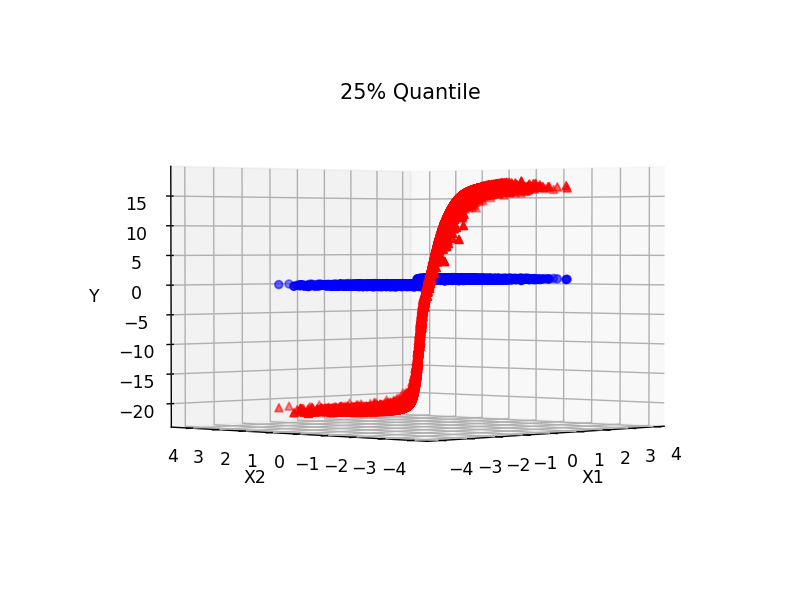

In [16]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, y_binary, marker='o',color='blue')
ax.scatter(X1, X2, quantile_pred, marker='^', color='red')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.title("25% Quantile")
plt.show()

In [17]:
mean_is = 0
std_is = 1
Q = np.array([0.5]).reshape(-1,1)

model  = new_model(Input((2,)),Q)

opt = Adam(lr= 0.001, clipnorm=1)
model.compile(optimizer = opt , loss=["sparse_categorical_crossentropy",lambda y,f: logLikelihoodLoss(y,f,mean_is,std_is,Q)])

model.fit(X3,[y_binary,y_binary],epochs=100,validation_split= 0.10)

c:\python36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  if __name__ == '__main__':


Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 1s 125us/step - loss: 0.8957 - dense_31_loss: 0.3353 - dense_32_loss: 0.5604 - val_loss: 0.4034 - val_dense_31_loss: 0.1559 - val_dense_32_loss: 0.2475
Epoch 2/100
9000/9000 [==============================] - 0s 35us/step - loss: 0.2780 - dense_31_loss: 0.1049 - dense_32_loss: 0.1731 - val_loss: 0.2138 - val_dense_31_loss: 0.0775 - val_dense_32_loss: 0.1363
Epoch 3/100
9000/9000 [==============================] - 0s 31us/step - loss: 0.1747 - dense_31_loss: 0.0644 - dense_32_loss: 0.1103 - val_loss: 0.1609 - val_dense_31_loss: 0.0597 - val_dense_32_loss: 0.1012
Epoch 4/100
9000/9000 [==============================] - 0s 32us/step - loss: 0.1409 - dense_31_loss: 0.0541 - dense_32_loss: 0.0867 - val_loss: 0.1391 - val_dense_31_loss: 0.0538 - val_dense_32_loss: 0.0853
Epoch 5/100
9000/9000 [==============================] - 0s 31us/step - loss: 0.1263 - dense_31_loss: 0.0509 - dense_32

9000/9000 [==============================] - 0s 29us/step - loss: 0.0982 - dense_31_loss: 0.0480 - dense_32_loss: 0.0502 - val_loss: 0.1019 - val_dense_31_loss: 0.0487 - val_dense_32_loss: 0.0531
Epoch 41/100
9000/9000 [==============================] - 0s 29us/step - loss: 0.0985 - dense_31_loss: 0.0482 - dense_32_loss: 0.0503 - val_loss: 0.1037 - val_dense_31_loss: 0.0500 - val_dense_32_loss: 0.0537
Epoch 42/100
9000/9000 [==============================] - 0s 29us/step - loss: 0.0979 - dense_31_loss: 0.0478 - dense_32_loss: 0.0501 - val_loss: 0.1023 - val_dense_31_loss: 0.0490 - val_dense_32_loss: 0.0533
Epoch 43/100
9000/9000 [==============================] - 0s 30us/step - loss: 0.0976 - dense_31_loss: 0.0478 - dense_32_loss: 0.0498 - val_loss: 0.1082 - val_dense_31_loss: 0.0526 - val_dense_32_loss: 0.0556
Epoch 44/100
9000/9000 [==============================] - 0s 31us/step - loss: 0.0993 - dense_31_loss: 0.0484 - dense_32_loss: 0.0509 - val_loss: 0.1017 - val_dense_31_loss: 0.0

9000/9000 [==============================] - 0s 32us/step - loss: 0.0969 - dense_31_loss: 0.0480 - dense_32_loss: 0.0489 - val_loss: 0.1003 - val_dense_31_loss: 0.0490 - val_dense_32_loss: 0.0513
Epoch 80/100
9000/9000 [==============================] - 0s 32us/step - loss: 0.0970 - dense_31_loss: 0.0480 - dense_32_loss: 0.0489 - val_loss: 0.0999 - val_dense_31_loss: 0.0488 - val_dense_32_loss: 0.0511
Epoch 81/100
9000/9000 [==============================] - 0s 31us/step - loss: 0.0968 - dense_31_loss: 0.0481 - dense_32_loss: 0.0487 - val_loss: 0.0998 - val_dense_31_loss: 0.0487 - val_dense_32_loss: 0.0511
Epoch 82/100
9000/9000 [==============================] - 0s 33us/step - loss: 0.0964 - dense_31_loss: 0.0478 - dense_32_loss: 0.0485 - val_loss: 0.1000 - val_dense_31_loss: 0.0488 - val_dense_32_loss: 0.0512
Epoch 83/100
9000/9000 [==============================] - 0s 32us/step - loss: 0.0964 - dense_31_loss: 0.0480 - dense_32_loss: 0.0484 - val_loss: 0.1016 - val_dense_31_loss: 0.0

In [18]:
y_pred_2, quantile_05pred = model.predict(X3)

<IPython.core.display.Javascript object>


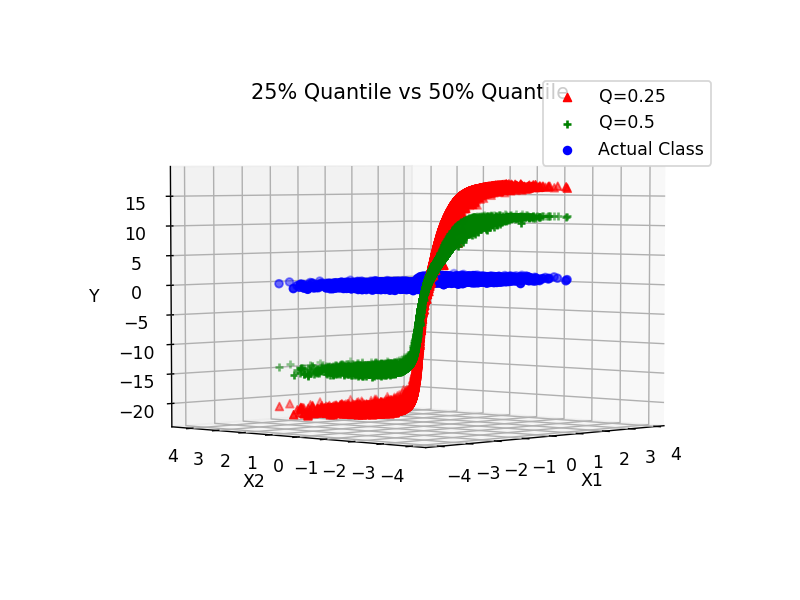

In [19]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, quantile_pred, marker='^', color='red', label="Q=0.25")
ax.scatter(X1, X2, quantile_05pred, marker='+',color='green',label="Q=0.5")
ax.scatter(X1, X2, y_binary, marker='o',color='blue', label="Actual Class")
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.title("25% Quantile vs 50% Quantile")
ax.legend()
plt.show()

In [20]:
count_50_binary = 0
count_50_indicator = 0
for i in range(len(quantile_05pred)):
    if quantile_05pred[i]>=y_binary[i]:
        count_50_binary +=1
    if quantile_05pred[i]>=y[i]:
        count_50_indicator +=1

print("Q=0.5 predicted covers:")
print(100*count_50_binary/len(quantile_05pred),"% of the binary response")
print(100*count_50_indicator/len(quantile_05pred),"% of the latent variable")

Q=0.5 predicted covers:
45.44 % of the binary response
48.1 % of the latent variable


In [22]:
count_25_binary = 0
count_25_indicator = 0
for i in range(len(quantile_pred)):
    if quantile_pred[i]>=y_binary[i]:
        count_25_binary +=1
    if quantile_pred[i]>=y[i]:
        count_25_indicator +=1

print("Q=0.25 predicted covers:")
print(100*count_25_binary/len(quantile_pred),"% of the binary response")
print(100*count_25_indicator/len(quantile_pred),"% of the latent variable")

Q=0.25 predicted covers:
45.2 % of the binary response
46.66 % of the latent variable
